In [ ]:
#### COLAB ONLY CELL
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/gdrive',force_remount=True)
%cd /content/gdrive/MyDrive/COMEXT
%pip install -r ./comext-graph-analysis/requirements.txt

In [74]:
import eurostat, random, math, os, pickle
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
from networkx.readwrite import json_graph
from networkx.classes.function import degree
import matplotlib.pyplot as plt

In [188]:
params_full = {
    "columns":['PRODUCT_CPA2_1', 'DECLARANT_ISO', 'PARTNER_ISO', 'TRADE_TYPE',  'FLOW', 'STAT_REGIME', 'PERIOD', "VALUE_IN_EUROS"],
    "years":[2021],
    "months":[1],
    "product":"all",
    "flow":"all",
    "trade_type":"all",
    "declarant_iso":"all",
    "partner_iso":"all"
}

params_tr = {
    "columns":['PRODUCT_NSTR', 'DECLARANT_ISO', 'PARTNER_ISO', 'FLOW', 'PERIOD', "TRANSPORT_MODE", "VALUE_IN_EUROS"],
    "years":[2021],
    "months":[1],
    "product":"all",
    "flow":"all",
    "declarant_iso":"all",
    "partner_iso":"all"
}

params_tr_intra = {
    "columns":['PRODUCT_NSTR', 'DECLARANT_ISO', 'PARTNER_ISO', 'FLOW', 'PERIOD', "TRANSPORT_MODE", "VALUE_IN_EUROS"],
    "years":[2021],
    "months":[1],
    "product":"all",
    "flow":"all",
    "declarant_iso":"all",
    "partner_iso":"all"
}


In [233]:
def load_filtered_data(table, params, save=False):

    def get_params_str(params):
        return str(params).replace("{","").replace("}","").replace("': ","_").replace("[","").replace("]","").replace(", ","_").replace("'","")

    prod_code_df = params["columns"][0]
    
    if os.path.exists(f"./data-samples/manual/{table}__{get_params_str(params)}.parquet"):
        if not os.path.exists(f"./data-samples/manual/"):
            os.makedirs(f"./data-samples/manual/")
        print("loading existing...",end=" ")
        df = pd.read_parquet(f"./data-samples/manual/{table}__{get_params_str(params)}.parquet")
        print("Table loaded")
    else:
        def build_filters(df,params,table,name):
            filters = pd.Series([True for i in range(df.shape[0])])
            if isinstance(params["product"],list):
                filter_prod = ~filters.copy()
                for p in params["product"]:
                    mask = (df[prod_code_df] == p)
                    if not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_prod = filter_prod | mask
                filters = filters & filter_prod
            elif params["product"] != "all":
                mask = (df[prod_code_df] == params["product"])
                if not mask.any():
                        print(f"{params['product']} not found in {table}{name}",end=", ")
                filters = filters & mask
            if params["flow"] != "all":
                filters = filters & (df.FLOW == params["flow"])
            if table == "full" and params["trade_type"] != "all":
                filters = filters & (df.TRADE_TYPE == params["trade_type"])
            if isinstance(params["declarant_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["declarant_iso"]:
                    mask = (df["DECLARANT_ISO"] == p)
                    if not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["declarant_iso"] != "all":
                mask = (df["DECLARANT_ISO"] == params["declarant_iso"])
                if not mask.any():
                    print(f"{params['declarant_iso']} not found in {table}{name}",end=", ")
            if isinstance(params["partner_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["partner_iso"]:
                    mask = (df["PARTNER_ISO"] == p)
                    if not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["partner_iso"] != "all":
                mask = (df["PARTNER_ISO"] == params["partner_iso"])
                if not mask.any():
                    print(f"{params['partner_iso']} not found in {table}{name}",end=", ")
            
            if not filters.any():
                print(f"\n\tempty df for {table}{name}")

            return filters

        if table not in ["full","tr","tr_intra_"]:
            raise Exception("table not valid")
        df = pd.DataFrame(columns=params["columns"])
        for y in params["years"]:
            print(y,end=" ")
            if params["months"] is None:
                df_y = pd.read_parquet(f"./data-samples/{table}/Years/{table}{y}52.parquet",columns=params["columns"])
                df = pd.concat([df,df_y[build_filters(df_y,params,table,str(y)+"52")].sort_values(params["columns"][-1],ascending=False)])
                del df_y
            elif params["months"] == "all":
                for m in range(1,13):
                    print(str(m),end=" ")
                    df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                    df = pd.concat([df,df_ym[build_filters(df_ym,params,table,str(y*100+m))].sort_values(params["columns"][-1],ascending=False)])
                del df_ym
            else:
                for m in params["months"]:
                    print(str(m),end=" ")
                    df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                    df = pd.concat([df,df_ym[build_filters(df_ym,params,table,str(y*100+m))].sort_values(params["columns"][-1],ascending=False)])
                del df_ym
        if df.shape[0] == 0:
            print("\n\tEmpty table")
        elif save:
            try:
                df.to_parquet(f"./data-samples/manual/{table}__{get_params_str(params)}.parquet")
            except:
                print("\nFailed saving, Table loaded")
        else:
            print(",\t Table loaded")
    return df.reset_index(drop=True).astype({prod_code_df:str,params["columns"][-1]:int,"FLOW":int}).dropna()

In [187]:
df_full = load_filtered_data("full",params_full,save=True)
df_tr = load_filtered_data("tr",params_tr,save=True)
df_tr_intra = load_filtered_data("tr_intra_",params_tr_intra,save=True)

2021 1 2021 1 2021 1 2 3 4 5 6 7 8 9 10 11 12 

In [189]:
def group_by_prod_code(table,n_digits,params):
    df = table.copy()
    column = df.columns[0]
    df[column] = df[column].str[:n_digits]
    return df.groupby(params["columns"][:-1],as_index=False).sum()

In [227]:
def estrai_tabella_per_grafo(df_in, flow=1, criterio="VALUE_IN_EUROS", transport_mode=None):

    df_out = df_in.copy()

    filters = True
    if "TRANSPORT_MODE" in df_out.columns:
        if transport_mode is None:
            df_out = df_out.groupby(df_out.columns[:-2].to_list(),as_index=False)[criterio].sum()
            # print(df_out.head())
        else:
            filters = filters & (df_out.TRASNPORT_MODE == transport_mode)
    # print(filters)
    filters = filters & (df_out.FLOW == flow)# & (df_out.DECLARANT_ISO != "EU") & (df_out.PARTNER_ISO != "EU")
    # print(filters.any(),filters)


    return df_out[filters].sort_values(criterio,ascending=False) 

def makeGraph(tab4graph, pos_ini=None, weight_flag=False, flow=[1], criterio="VALUE_IN_EUROS",threshold=0.001): 
    # costruisce sulla base della tabella filtrata
    # il grafo con le relative metriche

    def calc_metrics(Grafo,weight_flag):
        in_deg = nx.in_degree_centrality(Grafo)
        metrics = {}
        vulner = {}
        for k, v in in_deg.items():
            if v != 0 :      
                vulner[k] = 1 - v
            else:
                vulner[k] = 0            
        metrics={
                "degree": dict(nx.degree(Grafo)),
                "degree_centrality": nx.degree_centrality(Grafo),
                "density": nx.density(Grafo),
                "vulnerability": vulner,
                "out_degree_centrality": nx.out_degree_centrality(Grafo),
                "in_degree_centrality": nx.in_degree_centrality(Grafo),
                # "eigenvector_centrality": nx.eigenvector_centrality(Grafo),
                # "closeness_centrality":nx.closeness_centrality(Grafo),
                "clustering":nx.clustering(Grafo),
                "betweenness_centrality":nx.betweenness_centrality(Grafo),
                "hubness": nx.closeness_centrality(Grafo.to_undirected())
            }
        return metrics

    G = nx.DiGraph()

    # assegno i ruoli IMPORT e EXPORT

    edges = []
    for f in flow:
        if f == 1:
            country_from = "PARTNER_ISO"
            country_to = "DECLARANT_ISO"
        elif f == 2:
            country_from = "DECLARANT_ISO"
            country_to = "PARTNER_ISO"
        if weight_flag == True:
            divider = tab4graph.groupby(country_to,as_index=False)[criterio].sum()
            df = tab4graph.merge(divider,on=country_to,suffixes=("","_TOT"))
            df[criterio+"_SCALED"] = df[criterio] / df[criterio+"_TOT"]
            df = df[df[criterio+"_SCALED"] >= threshold]
            edges += [(i,j,w) for i,j,w in df.loc[:,[country_from,country_to,criterio+"_SCALED"]].values]
            # print(edges)
        else:
            edges += [(i,j,1) for i,j in df.loc[:,[country_from,country_to]].values]

    G.add_weighted_edges_from(edges)

    # Calcolo le metriche
    MetricG = calc_metrics(G, weight_flag)	
    
    # passo alla rappresentazione json del grafo
    GG = json_graph.node_link_data(G)
    Nodes = GG["nodes"]
    Links = GG["links"]

    if pos_ini is None:
        pos_ini = {}
        random.seed(8)
        for node in Nodes:
            x = random.uniform(0, 1)
            y = random.uniform(0, 1)
            pos_ini[node['id']] = np.array([x,y])
    try:
        coord = nx.spring_layout(G,k=5/math.sqrt(G.order()),pos=pos_ini)
        coord = nx.spring_layout(G,k=5/math.sqrt(G.order()),pos=coord) # stable solution
        # coord = nx.spring_layout(G,k=5/math.sqrt(G.order()),pos=coord) # stable solution
    except:
        return None,None,None

    #########################################################
    df_coord = pd.DataFrame.from_dict(coord,orient='index')
    df_coord.columns = ['x', 'y']

    df = pd.DataFrame(GG["nodes"])
    df.columns = ['label']
    df['id'] = np.arange(df.shape[0])
    df = df[['id', 'label']]    
    out = pd.merge(df, df_coord, left_on='label', right_index=True)
    dict_nodes = out.T.to_dict().values()
    
    dfe = pd.DataFrame(GG["links"])[["source" , "target"]]
    res = dfe.set_index('source').join(out[['label','id']].set_index('label'), on='source', how='left')
    res.columns = ['target', 'source_id']
    res2 = res.set_index('target').join(out[['label','id']].set_index('label'), on='target', how='left')
    res2.columns = ['from','to']
    res2.reset_index(drop=True, inplace=True)
    dict_edges = res2.T.to_dict().values()

    new_dict = { "nodes": list(dict_nodes), "edges": list(dict_edges), "metriche": MetricG}

    # JSON = json.dumps(new_dict) 

    return coord, new_dict, G

In [228]:
coord, graph, G = makeGraph(t4g,weight_flag=True)

In [179]:
df = df_tr[df_tr.FLOW == 1]
divider = df.groupby("DECLARANT_ISO",as_index=False).VALUE_IN_EUROS.sum()
df2 = df.merge(divider,on="DECLARANT_ISO",suffixes=("","_TOT"))
df2["VALUE_IN_EUROS_SCALED"] = df2.VALUE_IN_EUROS / df2.VALUE_IN_EUROS_TOT
edges = [(i,j,w) for i,j,w in df2.loc[:,["PARTNER_ISO","DECLARANT_ISO","VALUE_IN_EUROS"+"_SCALED"]].values]
df2 = df2.sort_values("VALUE_IN_EUROS_SCALED",ascending=False)
df2 = df2[df2.VALUE_IN_EUROS_SCALED >= 0.001]
df2

,PRODUCT_NSTR,PARTNER_ISO,FLOW,PERIOD,TRANSPORT_MODE,VALUE_IN_EUROS,DECLARANT_ISO,VALUE_IN_EUROS_TOT,VALUE_IN_EUROS_SCALED


In [ ]:
df = load_filtered_data("tr",params_tr,save=True)
df_group = group_by_prod_code(df,2,params_tr)

for prod in df_group.PRODUCT_NSTR.unique():
    df4g = df_group[df_group.PRODUCT_NSTR == prod][params_tr["columns"][1:]]
    t4g = estrai_tabella_per_grafo(df4g)
    coord, graph, G = makeGraph(t4g,weight_flag=True)
    metrics_tr_[f"{y}{m:02d}_nstr_{prod}"] = pd.DataFrame(graph["metriche"]).sort_values("degree",ascending=False)

In [231]:
df4g.dtypes

DECLARANT_ISO     object
PARTNER_ISO       object
FLOW              object
PERIOD            object
TRANSPORT_MODE    object
VALUE_IN_EUROS     int64
dtype: object

In [220]:
estrai_tabella_per_grafo(df4g)

  DECLARANT_ISO PARTNER_ISO FLOW  PERIOD  VALUE_IN_EUROS
0            AT          AE    1  201901           14324
1            AT          AZ    2  201901          349680
2            AT          CA    2  201901            4033
3            AT          CH    1  201901            8050
4            AT          CH    2  201901           81060
False


,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS


In [ ]:
metrics_tr = {}
for y,m in tqdm([(y,m) for y in range(2010,2022) for m in range(1,13)]):
    params_tr["years"]=[y]
    params_tr["months"]=[m]
    df = load_filtered_data("tr",params_tr,save=True)
    df_group = group_by_prod_code(df,2,params_tr)

    for prod in df_group.PRODUCT_NSTR.unique():
        df4g = df_group[df_group.PRODUCT_NSTR == prod][params_tr["columns"][1:]]
        t4g = estrai_tabella_per_grafo(df4g)
        coord, graph, G = makeGraph(t4g,weight_flag=True)
        metrics_tr[f"{y}{m:02d}_nstr_{prod}"] = pd.DataFrame(graph["metriche"]).sort_values("degree",ascending=False)

In [237]:
len(metrics_tr.keys())/144

53.0

In [ ]:
metrics_tr_intra = {}
for y,m in tqdm([(y,m) for y in range(2010,2022) for m in range(1,13)]):
    params_tr_intra["years"]=[y]
    params_tr_intra["months"]=[m]
    df = load_filtered_data("tr_intra_",params_tr_intra,save=True)
    df_group = group_by_prod_code(df,2,params_tr_intra)

    for prod in df_group.PRODUCT_NSTR.unique():
        df4g = df_group[df_group.PRODUCT_NSTR == prod][params_tr_intra["columns"][1:]]
        t4g = estrai_tabella_per_grafo(df4g)
        coord, graph, G = makeGraph(t4g,weight_flag=True)
        metrics_tr_intra[f"{y}{m:02d}_nstr_{prod}"] = pd.DataFrame(graph["metriche"]).sort_values("degree",ascending=False)

In [ ]:
metrics_full = {}
for y,m in tqdm.notebook.tqdm([(y,m) for y in range(2001,2022) for m in range(1,13)]):
    params_full["years"]=[y]
    params_full["months"]=[m]
    df = load_filtered_data("full",params_full,save=True)
    df_group = group_by_prod_code(df,2,params_full)

    for prod in df_group.PRODUCT_CPA2_1.unique():
        df4g = df_group[df_group.PRODUCT_CPA2_1 == prod][params_full["columns"][1:]]
        t4g = estrai_tabella_per_grafo(df4g)
        coord, graph, G = makeGraph(t4g,weight_flag=True)
        metrics_full[f"{y}{m:02d}_cpa_{prod}"] = pd.DataFrame(graph["metriche"]).sort_values("degree",ascending=False)

In [238]:
# pickle.dump(metrics_full,open("./data-samples/manual/metrics_full_01_21.pickle","wb"))
pickle.dump(metrics_tr,open("./data-samples/manual/metrics_tr_10_21.pickle","wb"))
# pickle.dump(metrics_tr_intra,open("./data-samples/manual/metrics_tr_intra_10_21.pickle","wb"))

In [23]:
df4g = df.groupby(["DECLARANT_ISO","PARTNER_ISO","TRADE_TYPE","FLOW"],as_index=False).VALUE_IN_EUROS.sum()

In [239]:
metrics_tr = pickle.load(open("./data-samples/manual/metrics_tr_10_21.pickle","rb"))

In [145]:
metrics_tr["202101_nstr_01"]

,degree,degree_centrality,density,vulnerability,out_degree_centrality,in_degree_centrality,clustering,betweenness_centrality,hubness
EU,141,0.839286,0.031382,0.160714,0.000000,0.839286,0,0.0,0.861538
FR,73,0.434524,0.031382,0.565476,0.000000,0.434524,0,0.0,0.507553
DE,67,0.398810,0.031382,0.601190,0.000000,0.398810,0,0.0,0.489796
NL,67,0.398810,0.031382,0.601190,0.000000,0.398810,0,0.0,0.489796
IT,57,0.339286,0.031382,0.660714,0.000000,0.339286,0,0.0,0.462810
...,...,...,...,...,...,...,...,...,...
MV,2,0.011905,0.031382,0.000000,0.011905,0.000000,0,0.0,0.466667
GA,2,0.011905,0.031382,0.000000,0.011905,0.000000,0,0.0,0.466667
SC,2,0.011905,0.031382,0.000000,0.011905,0.000000,0,0.0,0.466667
AO,2,0.011905,0.031382,0.000000,0.011905,0.000000,0,0.0,0.466667


In [240]:
def node_metrics_ts(metrics_dict,node,prod=None):
    node_rows = []
    for k in metrics_dict:
        ym, _, p = k.split("_")
        if prod == None:
            prod = p
        if prod == p:
            node_rows.append([ym] + metrics_dict[k].loc[node].to_list())
    return pd.DataFrame(node_rows,columns=(["Date"]+metrics_dict[k].columns.to_list())).set_index("Date")

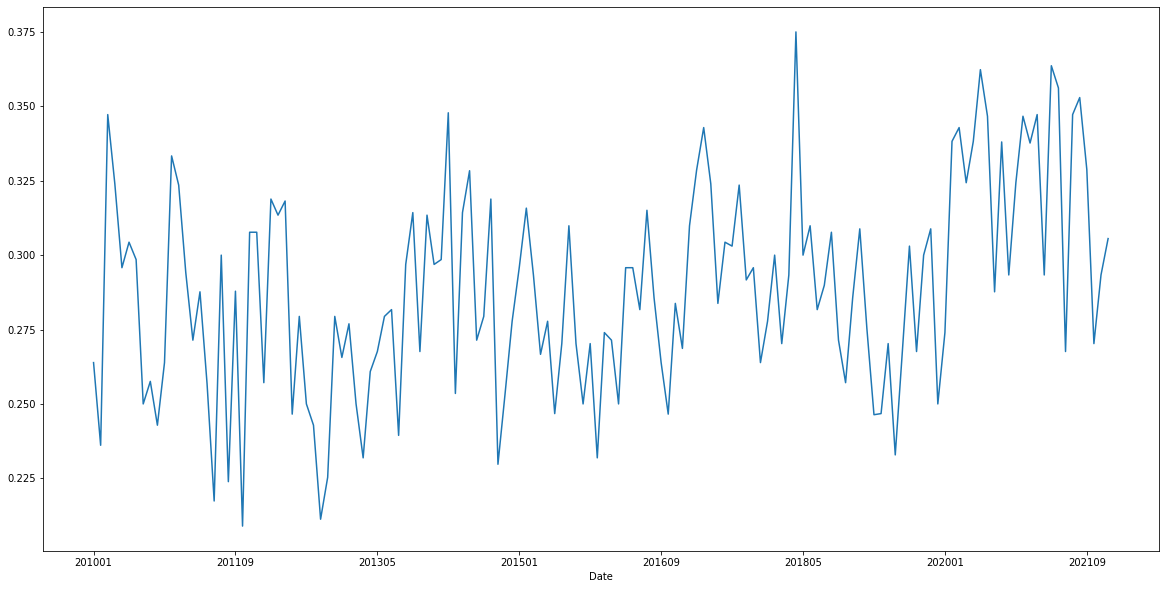

In [257]:
node_metrics_ts(metrics_tr,"DE",prod="01").in_degree_centrality.plot(figsize=(20,10))

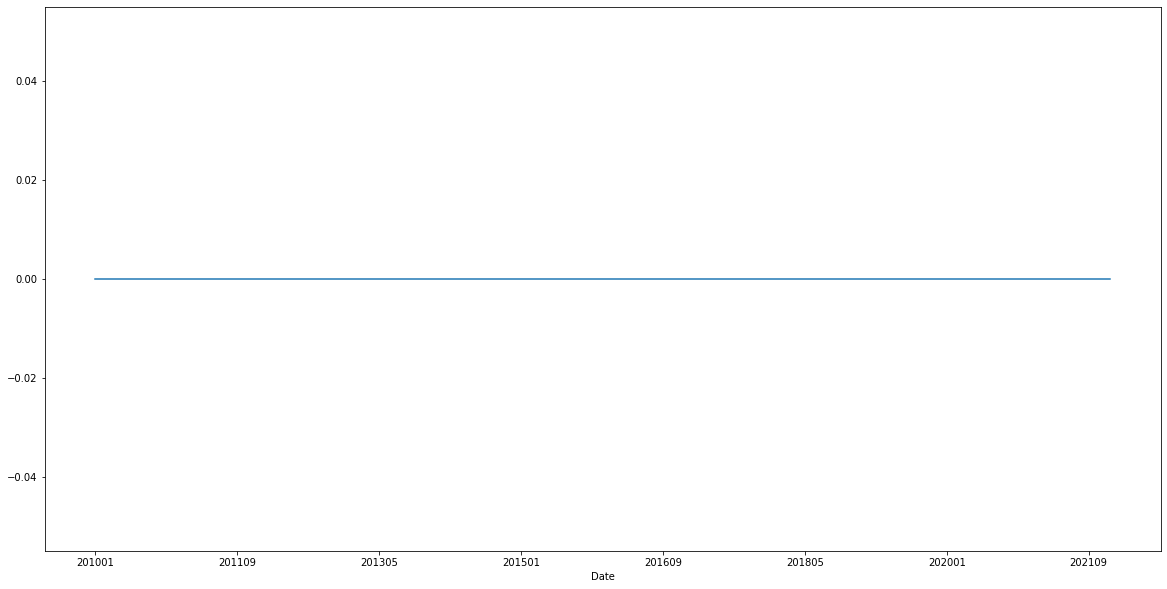

In [247]:
node_metrics_ts(metrics_tr,"IT",prod="01").out_degree_centrality.plot(figsize=(20,10))

# PLOTS

In [ ]:
t4g = estrai_tabella_per_grafo(df4g)

In [51]:
t4g[(t4g.DECLARANT_ISO == "DK")|(t4g.PARTNER_ISO == "DK")]

,PRODUCT_CPA2_1,DECLARANT_ISO,PARTNER_ISO,TRADE_TYPE,FLOW,STAT_REGIME,PERIOD,VALUE_IN_EUROS
97,TOTAL,DK,DE,I,1,1,202101,1498858875
143,TOTAL,DE,DK,I,1,1,202101,1037240587
159,TOTAL,DK,SE,I,1,1,202101,923253532
190,TOTAL,SE,DK,I,1,1,202101,747516212
223,TOTAL,DK,NL,I,1,1,202101,644888289
...,...,...,...,...,...,...,...,...
12608,TOTAL,DK,TR,E,1,2,202101,24
12612,TOTAL,DK,PF,E,1,1,202101,23
12615,TOTAL,DK,AE,E,1,2,202101,22
12651,TOTAL,DK,CU,E,1,1,202101,7


In [ ]:
coord, graph, G = makeGraph(t4g,weight_flag=True)

In [70]:
pd.DataFrame(graph["metriche"]).sort_values("degree",ascending=False)

,degree,degree_centrality,density,vulnerability,out_degree_centrality,in_degree_centrality,clustering,betweenness_centrality,hubness
NL,96,0.813559,0.095855,0.406780,0.220339,0.593220,0.332856,0.016059,0.728395
IT,95,0.805085,0.095855,0.415254,0.220339,0.584746,0.341999,0.012385,0.723926
ES,90,0.762712,0.095855,0.457627,0.220339,0.542373,0.370231,0.008635,0.706587
FR,87,0.737288,0.095855,0.483051,0.220339,0.516949,0.395161,0.007823,0.694118
GR,84,0.711864,0.095855,0.474576,0.186441,0.525424,0.376118,0.008708,0.686047
...,...,...,...,...,...,...,...,...,...
GQ,1,0.008475,0.095855,0.000000,0.008475,0.000000,0.000000,0.000000,0.411150
PA,1,0.008475,0.095855,0.000000,0.008475,0.000000,0.000000,0.000000,0.397306
BS,1,0.008475,0.095855,0.000000,0.008475,0.000000,0.000000,0.000000,0.397306
TD,1,0.008475,0.095855,0.000000,0.008475,0.000000,0.000000,0.000000,0.411150


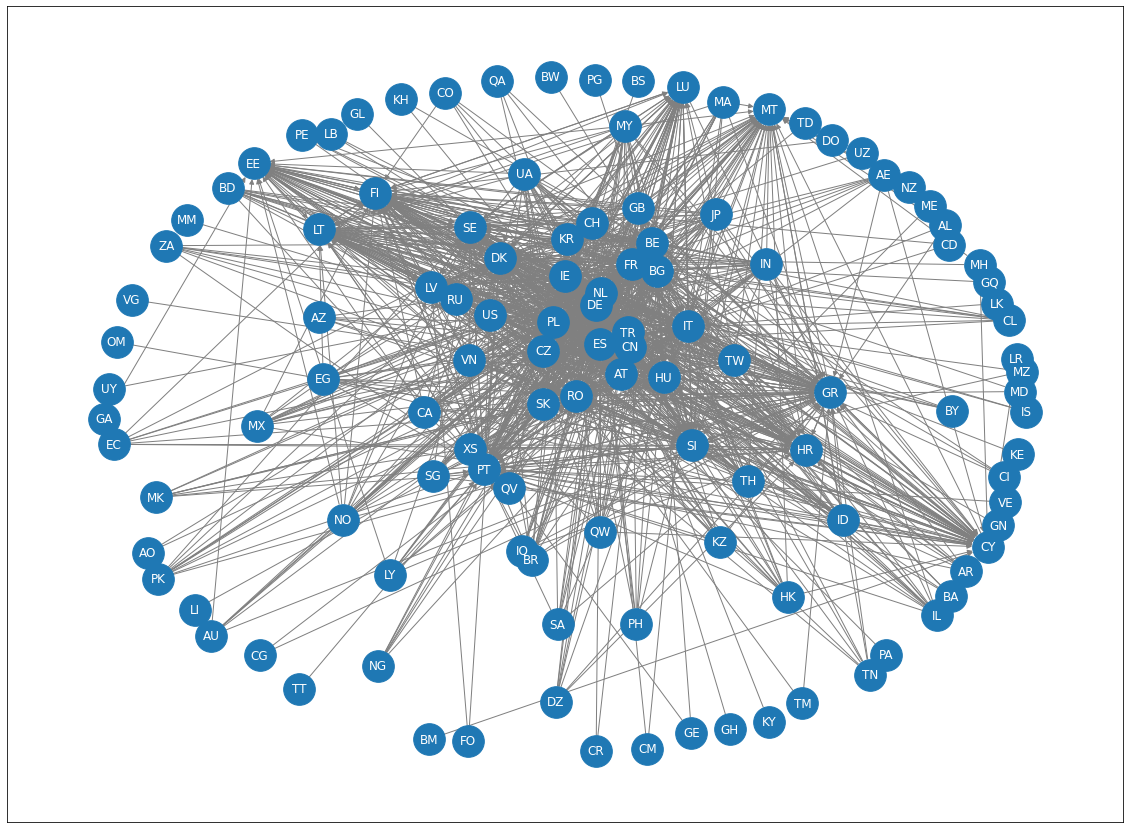

In [71]:
plt.figure(figsize=(20,15))
nx.draw_networkx(G,pos=coord,node_size=1000,font_color="white",font_size=12,edge_color="gray")

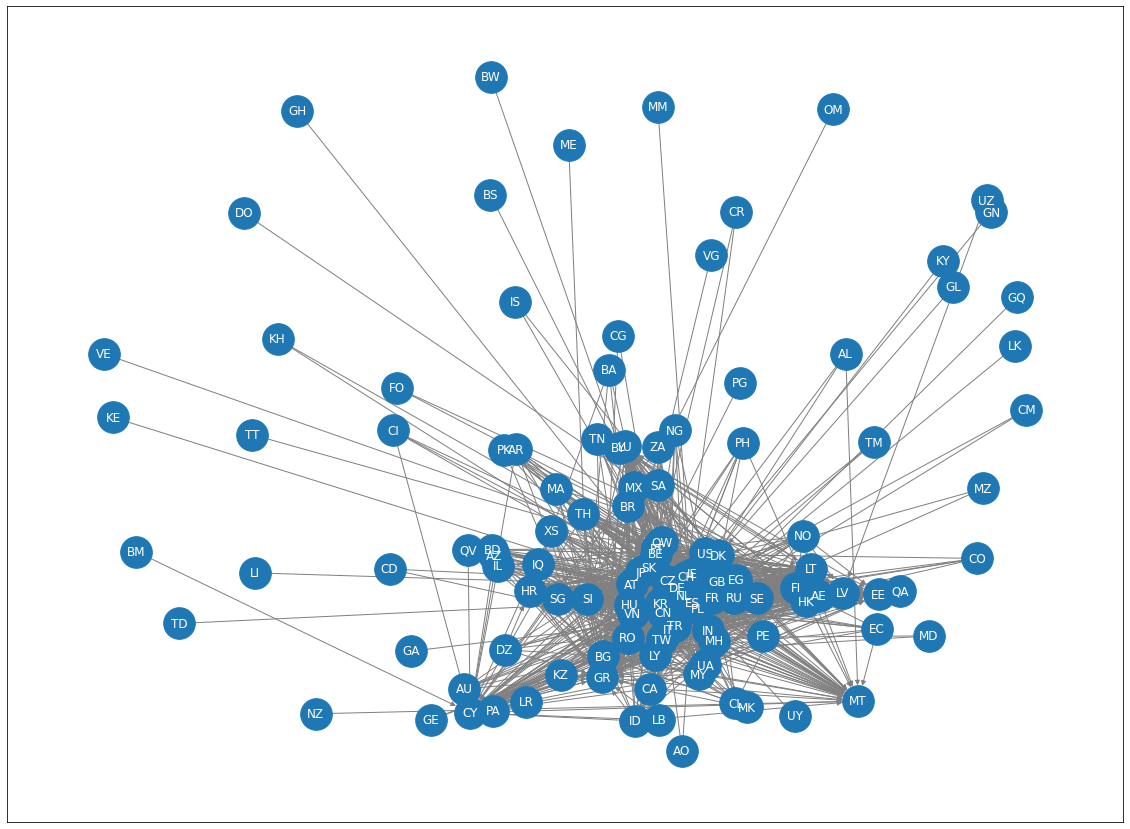

In [72]:
plt.figure(figsize=(20,15))
nx.draw_networkx(G,node_size=1000,font_color="white",font_size=12,edge_color="gray")